In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
!pwd

/workspace/notebooks


In [2]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook

tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np


from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
)
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

In [3]:
!nvidia-smi

Fri Mar 15 00:02:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           Off | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              N/A / ERR! |      1MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setup
Here we define some output paths.

In [4]:
#extract_features.confs
match_features.confs

{'superpoint+lightglue': {'output': 'matches-superpoint-lightglue',
  'model': {'name': 'lightglue', 'features': 'superpoint'}},
 'disk+lightglue': {'output': 'matches-disk-lightglue',
  'model': {'name': 'lightglue', 'features': 'disk'}},
 'superglue': {'output': 'matches-superglue',
  'model': {'name': 'superglue',
   'weights': 'outdoor',
   'sinkhorn_iterations': 50}},
 'superglue-fast': {'output': 'matches-superglue-it5',
  'model': {'name': 'superglue',
   'weights': 'outdoor',
   'sinkhorn_iterations': 5}},
 'NN-superpoint': {'output': 'matches-NN-mutual-dist.7',
  'model': {'name': 'nearest_neighbor',
   'do_mutual_check': True,
   'distance_threshold': 0.7}},
 'NN-ratio': {'output': 'matches-NN-mutual-ratio.8',
  'model': {'name': 'nearest_neighbor',
   'do_mutual_check': True,
   'ratio_threshold': 0.8}},
 'NN-mutual': {'output': 'matches-NN-mutual',
  'model': {'name': 'nearest_neighbor', 'do_mutual_check': True}},
 'adalam': {'output': 'matches-adalam', 'model': {'name': 'a

In [5]:
images = Path("../data/images")
outputs = Path("../data/hloc/demo/")
!rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

feature_conf = extract_features.confs["disk"]
matcher_conf = match_features.confs["disk+lightglue"]

In [6]:
# feature_conf["model"]["nms_radius"] = 28
feature_conf["preprocessing"]["resize_max"] = 256
feature_conf

{'output': 'feats-disk',
 'model': {'name': 'disk', 'max_keypoints': 5000},
 'preprocessing': {'grayscale': False, 'resize_max': 256}}

In [7]:
# matcher_conf["model"]["distance_threshold"] = 100.5
# matcher_conf["model"]["do_mutual_check"] = False
matcher_conf

{'output': 'matches-disk-lightglue',
 'model': {'name': 'lightglue', 'features': 'disk'}}

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

3 mapping images


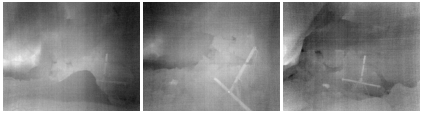

In [8]:
references = [p.relative_to(images).as_posix() for p in (images).iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [9]:
extract_features.main(
    feature_conf, images, image_list=references, feature_path=features
)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/03/15 00:02:03 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 256}}


  0%|          | 0/3 [00:00<?, ?it/s]

[2024/03/15 00:02:04 hloc INFO] Finished exporting features.
[2024/03/15 00:02:04 hloc INFO] Found 3 pairs.
[2024/03/15 00:02:04 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/3 [00:00<?, ?it/s]

[2024/03/15 00:02:07 hloc INFO] Finished exporting matches.


The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [10]:
f = extract_features.h5py.File("../data/hloc/demo/features.h5")
keypoints = np.array(f["image_00.png"]["keypoints"])
f.close()
keypoints.shape

(654, 2)

In [11]:
f = match_features.h5py.File("../data/hloc/demo/matches.h5")
kp_matches = np.where(np.array(f['image_01.png']['image_02.png']['matches0']) != -1) 
f.close()
kp_matches.shape #TODO supposedly not real matches

(array([  5,   6,  10,  14,  23,  33,  38,  40,  42,  45,  64,  70,  71,
         76,  77,  80,  85,  86,  91, 107, 109, 112, 116, 121, 122, 128,
        133, 139, 162, 163, 164, 169, 170, 211, 377, 396, 414, 421, 432,
        442, 447, 448, 459, 461, 467, 473, 474, 481, 488, 489, 490, 491,
        496, 497, 498, 504, 505, 507, 509, 512, 513, 515, 516, 519, 522,
        525, 526, 533, 534, 535, 536, 542, 543, 546, 549, 555, 558, 560,
        562, 569, 580, 582, 603, 622, 627, 629, 667]),)

[2024/03/15 00:02:07 hloc INFO] Creating an empty database...
[2024/03/15 00:02:07 hloc INFO] Importing images into the database...
[2024/03/15 00:02:07 hloc INFO] Importing features into the database...


  0%|          | 0/3 [00:00<?, ?it/s]

[2024/03/15 00:02:07 hloc INFO] Importing matches into the database...


  0%|          | 0/3 [00:00<?, ?it/s]

[2024/03/15 00:02:08 hloc INFO] Performing geometric verification of the matches...
I20240315 00:02:08.003021  2817 misc.cc:198] 
Custom feature matching
I20240315 00:02:08.004174  2817 feature_matching.cc:1021] Matching block [1/1]
I20240315 00:02:08.339108  2817 feature_matching.cc:46]  in 0.335s
I20240315 00:02:08.339272  2817 timer.cc:91] Elapsed time: 0.006 [minutes]
[2024/03/15 00:02:08 hloc INFO] Running 3D reconstruction...
I20240315 00:02:08.342116  2834 misc.cc:198] 
Loading database
I20240315 00:02:08.343391  2834 database_cache.cc:54] Loading cameras...
I20240315 00:02:08.343441  2834 database_cache.cc:64]  3 in 0.000s
I20240315 00:02:08.343456  2834 database_cache.cc:72] Loading matches...
I20240315 00:02:08.343482  2834 database_cache.cc:78]  3 in 0.000s
I20240315 00:02:08.343490  2834 database_cache.cc:94] Loading images...
I20240315 00:02:08.343719  2834 database_cache.cc:143]  3 in 0.000s (connected 3)
I20240315 00:02:08.343744  2834 database_cache.cc:154] Building cor

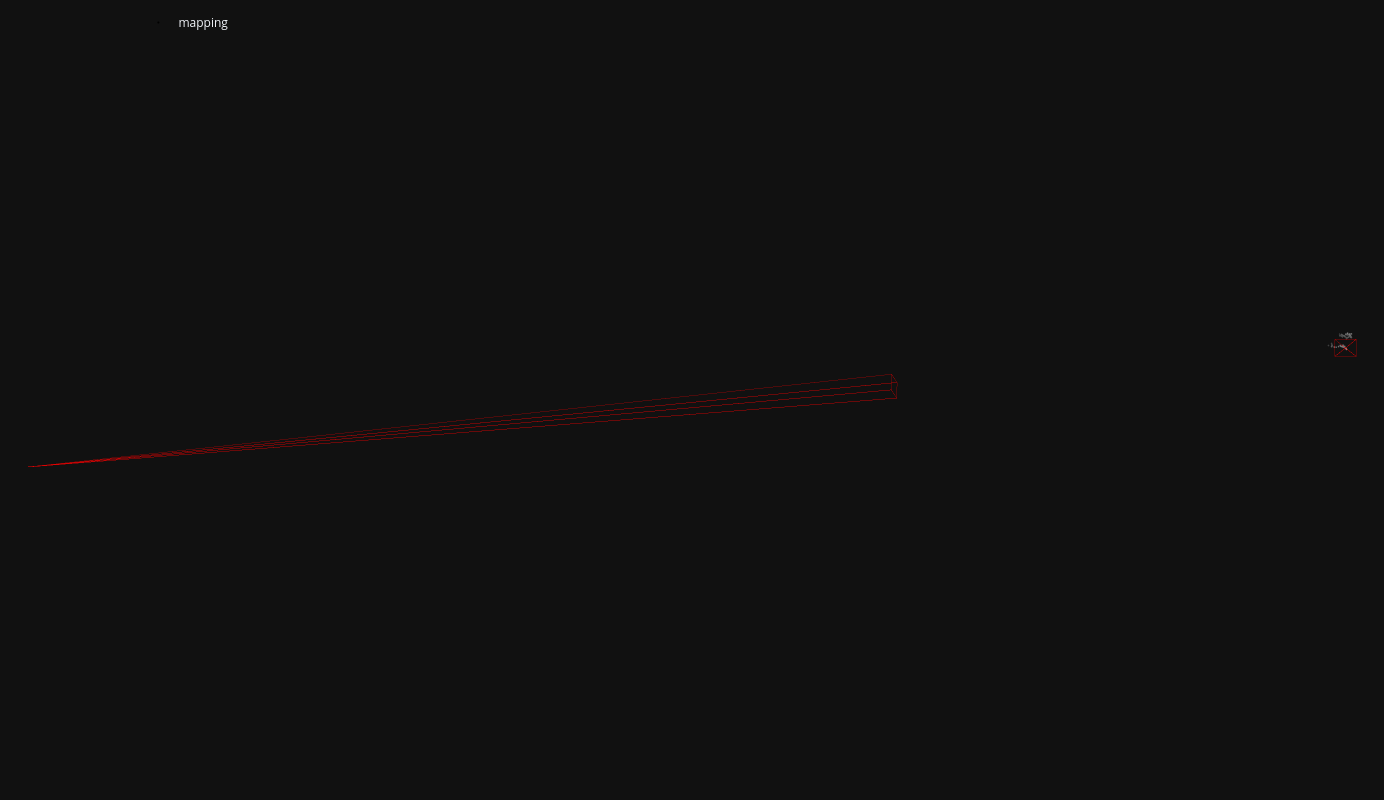

In [12]:
model = reconstruction.main(
    sfm_dir, images, sfm_pairs, features, matches, image_list=references
)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(
    fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True
)
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

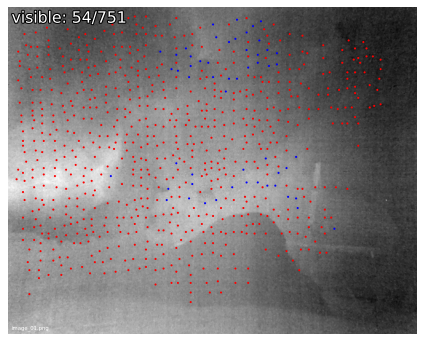

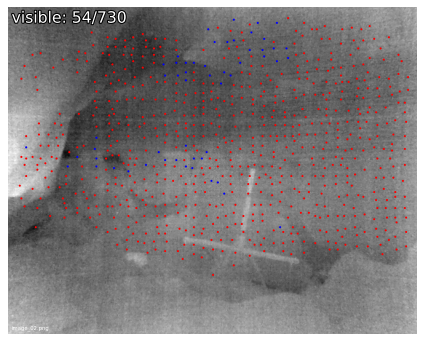

In [13]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=3)

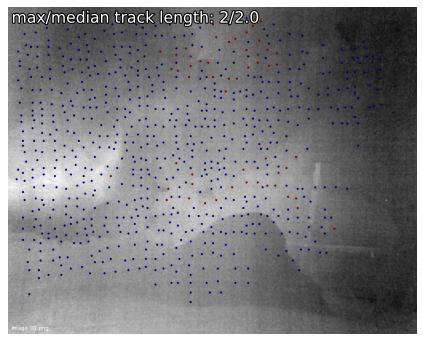

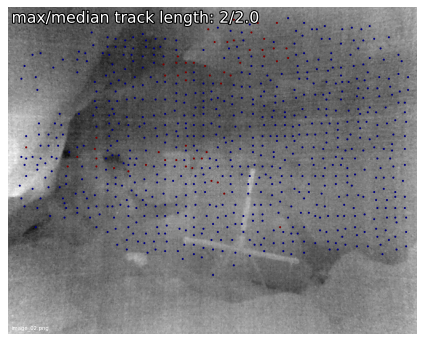

In [14]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=5)

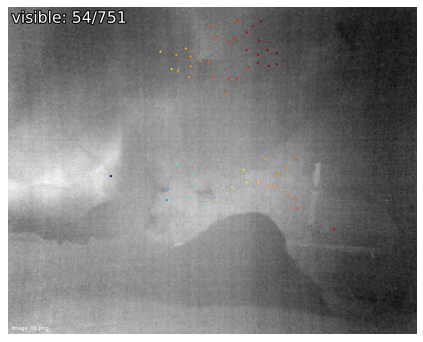

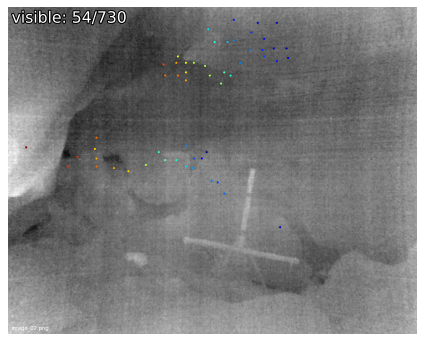

In [15]:
visualization.visualize_sfm_2d(model, images, color_by="depth", n=5)

# Colmap dense reconstruction (only with cuda)

In [16]:
import pycolmap

In [17]:
image_dir = images
output_path = outputs
mvs_path = output_path / "mvs"

In [18]:
# dense reconstruction
#pycolmap.undistort_images(mvs_path, output_path, image_dir)

In [19]:
pycolmap.patch_match_stereo(mvs_path)  # requires compilation with CUDA


AttributeError: module 'pycolmap' has no attribute 'patch_match_stereo'

In [ ]:
pycolmap.stereo_fusion(mvs_path / "dense.ply", mvs_path)

# loc

In [ ]:
query = "image_00.png"

In [ ]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r) for r in references]
ref_ids = [r.image_id for r in ref_ids if r is not None]
conf = {
    "estimation": {"ransac": {"max_error": 250}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)